ver2.  
변경사항: crawling 데이터 변경됨(news_df_210205_v03.xlsx → news_df_210222_v05.xlsx)  
기존 EDA 파일 정리사항 여기에 반영  
함수로 변경 삽입  

# Import

## Import library

In [1]:
import os
import sys
import warnings
from tqdm import tqdm, tqdm_notebook
import pickle

import numpy as np
import pandas as pd
from tabulate import tabulate

# 데이터 전처리
import re
from konlpy.tag import Okt
from konlpy.tag import Mecab
import rhinoMorph
from collections import Counter

# 데이터 시각화
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

warnings.filterwarnings(action='ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

# function

In [2]:
def setDIR():
    # 현재 jupyter 위치를 PROJECT_DIR 추가
    PROJECT_DIR = os.path.abspath(os.path.join(os.path.realpath('__file__'), '..'))
    sys.path.insert(0, PROJECT_DIR)
    DATA_DIR = PROJECT_DIR + '/data' # 데이터 위치 
    print(DATA_DIR)
    
    return DATA_DIR

In [3]:
def cleaningData(data, drop_col_name, sort_col_name):
    '''
    데이터를 정제해주는 함수입니다. 
    1) 기준 column에 None이 존재하는 경우 drop을 진행하고, 정제를 합니다.
    2) 인덱스를 초기화해줍니다.
    
    Parameters: 
    ---------- 
    data : DataFrame
        정제 대상
    drop_col_name : str
        내용이 없는 경우 drop하고 정제할 column의 이름
    sort_col_name : str
        최종 DataFrame의 정렬 기준이 되는 column의 이름
    
    Returns: 
    ------- 
    df : DataFrame
        정제한 데이터
    '''
    df = data.copy()
    print(drop_col_name, '--- None 개수: ', df[drop_col_name].isna().sum())
    print('\n\n=== 제거 데이터 ===\n', tabulate(df.loc[data[drop_col_name].isna()]))
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True) # drop 후 인덱스가 변경되지 않아 index reset 진행
    df[drop_col_name] = df[drop_col_name].apply(lambda x: re.sub(r'[^A-Za-z0-9가-힣 ]','',x.replace('.',' '))) # cleaning
    df.sort_values(by=[sort_col_name], inplace=True) # 정렬
    
    return df

In [4]:
def tokenizeData(text, stopwords, module, option=None):
    '''
    텍스트를 토큰화하고 불용어를 제거하여 문자길이가 2이상인 단어를 추출하는 함수입니다. 
    
    Parameters: 
    ---------- 
    text : str
        토큰화 대상
    stopwords : list[str,...,str]
        불용어 리스트
    module : str
        모듈 입력 가능 리스트 입니다.
        - 'okt.morphs', 'okt.morphs', 'okt.nouns', 'mecab.morphs', 'mecab.nouns', 'rhino'
    option : str, default = None
        okt.morphs에 옵션을 추가하는 경우로, 'stem' 또는 'norm'를 입력합니다.
        - stem: 각 단어 어간 추출, norm : 문장정규화
    
    Returns: 
    ------- 
    token : list[str,...,str]
         토큰화된 데이터
    '''

    r = re.compile("okt*")
    isOkt = False
    if r.search(module) is None:
        pass
    else:
        isOkt = True
        
    token = []
    if isOkt:
        okt = Okt()
        if module == 'okt.morphs':
            if option == None:
                token = okt.morphs(text)
            elif option == 'stem':
                token = okt.morphs(text, stem = True)
            elif option == 'norm':
                token = okt.morphs(text, norm = True)
        elif module == 'okt.nouns':
            token = okt.nouns(text)
    elif module == 'mecab.morphs':
        mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
        token = mecab.morphs(text)
    elif module == 'mecab.nouns':
        mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
        token = mecab.nouns(text)
    elif module == 'rhino':
        # 실질형태소, NNG: 일반명사 / NNP: 고유명사 / VA: 형용사
        rhino = rhinoMorph.startRhino()
        token = rhinoMorph.onlyMorph_list(rhino, text, pos=['NNG','NNP','VA'], combineN=True)
    
    if len(token) > 0:
        token = [word for word in token if word not in stopwords if len(word) > 1]
    
    return token

In [42]:
def display_voca_count(data_series, voca_num=30, figsize=(15,10)):
    '''
    토큰화된 데이터 컬럼의 단어를 카운트하여 출현 빈도수가 높은 순으로 bar 그래프로 보여주는 함수입니다. 
    
    Parameters: 
    ---------- 
    data_series : pandas Series
        토큰화된 데이터
    voca_num : int
        단어 수, default = 30
    figsize : (width, height)
        그래프 사이즈, default = (15,10)
        - 'okt.morphs', 'okt.morphs', 'okt.nouns', 'mecab.morphs', 'mecab.nouns', 'rhino'
    
    '''
    
    ds = data_series.copy()
    sorted_keys = ds.apply(lambda x : x[0]).tolist()
    sorted_values = ds.apply(lambda x : x[1]).tolist()

    plt.figure(figsize=figsize)
    plt.rc('font', family='NanumGothic') 
    plt.bar(range(voca_num), sorted_values[:voca_num], color='#9999ff')
    plt.xticks(range(voca_num), sorted_keys[:voca_num], rotation=90)
    plt.grid(True)
    plt.show()

# main

## import

In [6]:
DATA_DIR = setDIR()

C:\Users\lime1\Documents\study\Python\project/data


In [7]:
data = pd.read_excel(DATA_DIR +'/news_df_210222_v05.xlsx')
data.info()
data.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   media             861 non-null    object
 1   date              861 non-null    object
 2   title             861 non-null    object
 3   article_original  853 non-null    object
 4   url               861 non-null    object
dtypes: object(5)
memory usage: 33.8+ KB


,media,date,title,article_original,url
0,조선일보,2020-01-02,150만명 몰린 타임스스퀘어 새해 무대도 BTS,2012년 싸이에 이어 두 번째 ABC방송 라이브 쇼에서 생중계 전 지구를 홀린 ...,https://news.naver.com/main/read.nhn?mode=LSD&...
1,조선일보,2020-01-02,방탄소년단 CNN 선정 2010년대 음악 변화시킨 아티스트,방탄소년단BTS이 미국 CNN 선정 2010년대 음악을 변화시킨 10대 아티스트에...,https://news.naver.com/main/read.nhn?mode=LSD&...


# 데이터 전처리

## 사용 데이터 정리
기사 본문이 존재하지 않는 8개의 기사는 삭제하고자 합니다.

In [8]:
data_df = cleaningData(data, drop_col_name = 'article_original', sort_col_name = 'date')

article_original --- None 개수:  8


=== 제거 데이터 ===
 ---  --------  ----------  -----------------------------------------------------------------------------------------------------------------------  ---  -------------------------------------------------------------------------------------
157  중앙일보  2020-03-22  민기자야 BTS 기사 쓴 기자가 직접 자기 기사 댓글 읽었다                                                                   nan  https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=103&oid=025&aid=0002986222
211  조선일보  2020-05-15  사진 BTS RM이 남긴 미술관 방명록쉽지 않은 시기 같이 이겨내요                                                             nan  https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=103&oid=023&aid=0003531504
405  한겨레    2020-09-02  영상 BTS 빌보드 핫 100 1위온라인 글로벌 기자간담회                                                                       nan  https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=103&oid=028&aid=0002511264
407  경향신문  2020-09-02  BTS Makes It over the Final Billboard Thres

In [9]:
# 전처리 확인
idx = 4
print('--- cleaning 전 ---\n', data['article_original'].iloc[idx], '\n\n')
print('--- cleaning 후 ---\n', data_df['article_original'].iloc[idx], '\n\n')
data_df.info()

--- cleaning 전 ---
  골든글로브 시상식에서 한국 최초로 외국어영화상을 수상한 기생충의 봉준호 감독이 한 매체와 인터뷰 중 방탄소년단BTS을 언급하며 한국을 멋진 아티스트들의 나라라고 표현했다. 봉준호 감독은 6일 오전한국시각 미국 로스앤젤레스 베버리 힐튼호텔에서 열린 제77회 골든글로브 시상식 레드카펫 행사에서 캐나다의 CTV eTALK와 인터뷰 중 한국 콘텐츠의 영향력에 대해 이같이 밝혔다. 봉 감독은 제가 비록 골든글로브에 와 있긴 하지만 BTS가 누리는 파워와 힘은 저의 3000배 이상이라며 그런 멋진 아티스트들이 많이 나올 수밖에 없는 나라인 것 같다. 감정적으로 격렬하고 다이나믹한 나라라고 밝혔다. 한편 이날 봉준호 감독의 영화 기생충은 한국 영화 최초로 골든글로브상을 받는 쾌거를 올렸다. 골든글로브가 아카데미오스카의 전초전으로 불리는 만큼 내달 9일 아카데미 시상식에서도 수상 가능성을 한껏 끌어올렸다는 평가다. 기생충은 각본상과 감독상 후보에도 선정됐지만 아쉽게도 수상에는 실패했다. 이날 각본상은 원스 어폰 어 타임 인 할리우드의 쿠엔틴 타란티노 감독에게 돌아갔고 감독상은 1917의 샘 멘데스 감독이 수상했다. 


--- cleaning 후 ---
  골든글로브 시상식에서 한국 최초로 외국어영화상을 수상한 기생충의 봉준호 감독이 한 매체와 인터뷰 중 방탄소년단BTS을 언급하며 한국을 멋진 아티스트들의 나라라고 표현했다  봉준호 감독은 6일 오전한국시각 미국 로스앤젤레스 베버리 힐튼호텔에서 열린 제77회 골든글로브 시상식 레드카펫 행사에서 캐나다의 CTV eTALK와 인터뷰 중 한국 콘텐츠의 영향력에 대해 이같이 밝혔다  봉 감독은 제가 비록 골든글로브에 와 있긴 하지만 BTS가 누리는 파워와 힘은 저의 3000배 이상이라며 그런 멋진 아티스트들이 많이 나올 수밖에 없는 나라인 것 같다  감정적으로 격렬하고 다이나믹한 나라라고 밝혔다  한편 이날 봉준호 감독의 영화 기생충은 한국 영화 최초로 골든글로브상을 받는 쾌거를 올렸다  골든글

# 단어 토큰화

토큰화 시 불용어를 삭제하기 위해 stop word를 파일을 불러옵니다.   
stopwords 출처: https://www.ranks.nl/stopwords/korean  

In [10]:
stopwords = open(DATA_DIR+'/stopwords.txt','r', encoding='utf-8').read().split('\n')
stopwords[:10]

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']

기사 원문에 대하여 4가지 방식으로 단어 토큰화를 진행하여 가장 결과가 좋은 것을 선택하고자 합니다.
- konlpy : Okt(morphs, nouns), Mecab(nouns)
- rhinoMorph

이와 동시에 불용어를 제거하며, 1글자 이하는 제거합니다.

In [11]:
# token test용 dataframe
token_df = data_df[['media','date','article_original']].copy()

In [12]:
test_text = token_df['article_original'].iloc[4]
print('--- [원문] ---\n\n', test_text, '\n\n')

--- [원문] ---

  골든글로브 시상식에서 한국 최초로 외국어영화상을 수상한 기생충의 봉준호 감독이 한 매체와 인터뷰 중 방탄소년단BTS을 언급하며 한국을 멋진 아티스트들의 나라라고 표현했다  봉준호 감독은 6일 오전한국시각 미국 로스앤젤레스 베버리 힐튼호텔에서 열린 제77회 골든글로브 시상식 레드카펫 행사에서 캐나다의 CTV eTALK와 인터뷰 중 한국 콘텐츠의 영향력에 대해 이같이 밝혔다  봉 감독은 제가 비록 골든글로브에 와 있긴 하지만 BTS가 누리는 파워와 힘은 저의 3000배 이상이라며 그런 멋진 아티스트들이 많이 나올 수밖에 없는 나라인 것 같다  감정적으로 격렬하고 다이나믹한 나라라고 밝혔다  한편 이날 봉준호 감독의 영화 기생충은 한국 영화 최초로 골든글로브상을 받는 쾌거를 올렸다  골든글로브가 아카데미오스카의 전초전으로 불리는 만큼 내달 9일 아카데미 시상식에서도 수상 가능성을 한껏 끌어올렸다는 평가다  기생충은 각본상과 감독상 후보에도 선정됐지만 아쉽게도 수상에는 실패했다  이날 각본상은 원스 어폰 어 타임 인 할리우드의 쿠엔틴 타란티노 감독에게 돌아갔고 감독상은 1917의 샘 멘데스 감독이 수상했다  




In [13]:
# okt, mecab 토큰화 확인
module_list = ['okt.morphs','okt.morphs_stem','okt.morphs_norm','okt.nouns','mecab.morphs','mecab.nouns']
for m in module_list:
    m = m.split('_')
    module = m[0]
    option = None
    if len(m)>1:
        option = m[1]
    result = tokenizeData(test_text, stopwords, module, option)
    print('--- ', m, ' ---\n\n', result, '\n\n')

---  ['okt.morphs']  ---

 ['골든글로브', '시상식', '한국', '최초', '외국어', '영화상', '수상한', '기생충', '봉준호', '감독', '매체', '인터뷰', '방탄소년단', 'BTS', '언급', '하며', '한국', '멋진', '아티스트', '나라', '라고', '표현', '했다', '봉준호', '감독', '6일', '오전', '한국', '미국', '로스앤젤레스', '베버', '힐튼', '호텔', '열린', '77회', '골든글로브', '시상식', '레드카펫', '행사', '캐나다', 'CTV', 'eTALK', '인터뷰', '한국', '콘텐츠', '영향력', '대해', '이같이', '밝혔다', '감독', '골든글로브', '있긴', 'BTS', '누리는', '파워', '3000', '이라', '그런', '멋진', '아티스트', '많이', '나올', '밖에', '없는', '나라', '감정', '격렬하고', '다이나믹', '나라', '라고', '밝혔다', '한편', '봉준호', '감독', '영화', '기생충', '한국', '영화', '최초', '골든글로브상', '받는', '쾌거', '올렸다', '골든글로브', '아카데미', '오스카', '전초전', '불리는', '만큼', '내달', '9일', '아카데미', '시상식', '에서도', '수상', '가능성', '한껏', '끌어', '올렸다는', '평가', '기생충', '각본', '상과', '감독', '후보', '에도', '선정', '됐지만', '아쉽게도', '수상', '에는', '실패했다', '각본', '원스', '어폰', '타임', '할리우드', '쿠엔틴', '타란티노', '감독', '돌아갔고', '감독', '1917', '데스', '감독', '수상했다'] 


---  ['okt.morphs', 'stem']  ---

 ['골든글로브', '시상식', '한국', '최초', '외국어', '영화상', '수상한', '기생충', '봉준호', '감독', '하다', '매체', '인터뷰'

In [13]:
module = 'rhino'
result = tokenizeData(test_text, stopwords, module)
print('--- ', module, '---\n\n', result, '\n\n')

filepath:  C:\Users\lime1\anaconda3\Lib\site-packages
classpath:  C:\Users\lime1\anaconda3\Lib\site-packages\rhinoMorph/lib/rhino.jar
RHINO started!
---  rhino ---

 ['골든글로브', '시상식', '한국', '최초', '외국어영화상', '수상', '기생충', '봉준호', '감독', '매체', '인터뷰', '방탄', '한국', '멋지', '아티스트', '나라', '봉준호', '감독', '오전한국시각', '미국', '로스앤젤레스', '베버', '힐튼호텔', '열린', '골든글로브', '시상식', '레드카펫', '행사', '캐나다', '인터뷰', '한국', '콘텐츠', '영향력', '감독', '골든글로브', '파워', '저의', '멋지', '아티스트', '나라', '감정적', '다이나믹', '나라', '이날', '봉준호', '감독', '영화', '기생충', '한국', '영화', '최초', '골든글로브상', '쾌거', '골든글로브', '아카데미오스카', '전초전', '내달', '아카데미', '시상식', '수상', '가능성', '평가', '기생충', '각본상', '감독상', '후보', '아쉽', '수상', '이날', '각본상', '원스', '어폰', '타임', '할리우드', '쿠엔틴', '타란티노', '감독', '감독상', '데스', '감독'] 




위 3가지 결과를 비교하여 okt의 형태소(morph)단위 토큰화는 stem 옵션을 추가하여 어간을 추출한 경우를 적용하여 비교하기로 하였다.  
- vocab count 시 용이할 것으로 보임.

In [15]:
module_list = ['okt.morphs','okt.morphs_stem','okt.morphs_norm','mecab.morphs','okt.nouns','mecab.nouns']

tqdm.pandas()
for module_ in tqdm_notebook(module_list):
    m = module_.split('_')
    module = m[0]
    option = None
    if len(m)>1:
        option = m[1]
    
    token_df[module_] = token_df.article_original.progress_apply(lambda x: tokenizeData(x, stopwords, module, option))

100%|████████████████████████████████████████████████████████████████████████████████| 853/853 [00:14<00:00, 58.97it/s]

In [16]:
token_df

,media,date,article_original,okt.morphs,okt.morphs_stem,okt.morphs_norm,mecab.morphs,okt.nouns,mecab.nouns
0,조선일보,2020-01-02,2012년 싸이에 이어 두 번째 ABC방송 라이브 쇼에서 생중계 전 지구를 홀린 ...,"[2012년, 싸이, 이어, 번째, ABC, 방송, 라이브, 생중계, 지구, 홀린,...","[2012년, 싸이, 이다, 번째, ABC, 방송, 라이브, 생중계, 지구, 홀린,...","[2012년, 싸이, 이어, 번째, ABC, 방송, 라이브, 생중계, 지구, 홀린,...","[2012, 싸이, 이어, ABC, 방송, 라이브, 중계, 지구, 홀린, 그룹, 입...","[싸이, 방송, 라이브, 생중계, 지구, 홀린, 그룹, 사회자, 소개, 방탄소년단,...","[싸이, 방송, 라이브, 중계, 지구, 그룹, 사회, 소개, 방탄소년단, 모습, 마..."
1,조선일보,2020-01-02,방탄소년단BTS이 미국 CNN 선정 2010년대 음악을 변화시킨 10대 아티스트에...,"[방탄소년단, BTS, 미국, CNN, 선정, 2010년, 음악, 변화, 시킨, 1...","[방탄소년단, BTS, 미국, CNN, 선정, 2010년, 음악, 변화, 10, 대...","[방탄소년단, BTS, 미국, CNN, 선정, 2010년, 음악, 변화, 시킨, 1...","[방탄소년단, BTS, 미국, CNN, 선정, 2010, 음악, 변화, 시킨, 10...","[방탄소년단, 미국, 선정, 음악, 변화, 아티스트, 선정, 음악, 장르, 스스로,...","[방탄소년단, 미국, 선정, 음악, 변화, 아티스트, 선정, 현지, 음악, 장르, ..."
2,조선일보,2020-01-03,트와이스 도쿄돔 공연 블랙핑크도 새앨범 예정 경자년 새해에도 K팝 스타들의 세계...,"[트와이스, 도쿄돔, 공연, 블랙, 핑크, 앨범, 예정, 경자년, 새해, 에도, 스...","[트와이스, 도쿄돔, 공연, 블랙, 핑크, 앨범, 예정, 경자년, 새해, 에도, 스...","[트와이스, 도쿄돔, 공연, 블랙, 핑크, 앨범, 예정, 경자년, 새해, 에도, 스...","[이스, 도쿄, 공연, 블랙, 핑크, 앨범, 예정, 경자, 새해, 스타, 세계, 무...","[트와이스, 도쿄돔, 공연, 블랙, 핑크, 앨범, 예정, 경자년, 새해, 스타, 세...","[이스, 도쿄, 공연, 블랙, 핑크, 앨범, 예정, 경자, 새해, 스타, 세계, 무..."
3,조선일보,2020-01-03,K팝에 대한 관심이 전 세계적으로 높아지면서 서울시가 이른바 K팝 명소들을 선정해...,"[대한, 관심, 세계, 높아지면서, 서울시, 이른바, 명소, 선정, 홍보, 하고, ...","[대한, 관심, 세계, 높아지다, 서울시, 이른바, 명소, 선정, 하다, 홍보, 하...","[대한, 관심, 세계, 높아지면서, 서울시, 이른바, 명소, 선정, 홍보, 하고, ...","[대한, 관심, 세계, 면서, 서울시, 이른, 명소, 선정, 홍보, 멀리서, 한국,...","[대한, 관심, 세계, 서울시, 명소, 선정, 홍보, 멀리, 한국, 외국인, 관광객...","[관심, 세계, 서울시, 명소, 선정, 홍보, 한국, 외국인, 관광객, 방탄소년단,..."
4,조선일보,2020-01-06,골든글로브 시상식에서 한국 최초로 외국어영화상을 수상한 기생충의 봉준호 감독이 한...,"[골든글로브, 시상식, 한국, 최초, 외국어, 영화상, 수상한, 기생충, 봉준호, ...","[골든글로브, 시상식, 한국, 최초, 외국어, 영화상, 수상한, 기생충, 봉준호, ...","[골든글로브, 시상식, 한국, 최초, 외국어, 영화상, 수상한, 기생충, 봉준호, ...","[골든, 글로브, 시상식, 한국, 최초, 외국어, 영화상, 수상, 기생충, 봉준호,...","[골든글로브, 시상식, 한국, 최초, 외국어, 영화상, 수상한, 기생충, 봉준호, ...","[골든, 글로브, 시상식, 한국, 최초, 외국어, 영화상, 기생충, 봉준호, 감독,..."
...,...,...,...,...,...,...,...,...,...
848,한겨레,2020-12-26,방탄소년단BTS의 전세계적인 인기는 이제 낯설지 않다 2017년 처음 미국 무대...,"[방탄소년단, BTS, 전세계, 인기, 이제, 낯설지, 않다, 2017년, 처음, ...","[방탄소년단, BTS, 전세계, 인기, 이제, 낯설다, 않다, 2017년, 처음, ...","[방탄소년단, BTS, 전세계, 인기, 이제, 낯설지, 않다, 2017년, 처음, ...","[방탄소년단, BTS, 세계, 인기, 이제, 낯설, 2017, 처음, 미국, 무대,...","[방탄소년단, 전세계, 인기, 이제, 처음, 미국, 무대, 지난, 빌보드, 아메리칸...","[방탄소년단, 세계, 인기, 처음, 미국, 무대, 빌보드, 아메리칸, 뮤직, 어워드..."
849,한겨레,2020-12-26,이 세계의 모든 힘없는 자들아 우리가 패배할 날이 올지도 모르지만 오늘은 아니야 ...,"[세계, 모든, 힘없는, 패배할, 지도, 모르지만, 오늘, 아니야, 오늘, 싸워, ...","[세계, 모든, 힘없다, 패배하다, 지도, 모르다, 오늘, 아니다, 오늘, 싸우다,...","[세계, 모든, 힘없는, 패배할, 지도, 모르지만, 오늘, 아니야, 오늘, 싸워, ...","[세계, 모든, 패배, 올지, 모르, 오늘, 오늘, 싸워, 투데이, 가운데, 방탄소...","[세계, 모든, 지도, 오늘, 오늘, 투데이, 가운데, 방탄소년단, 자체, 혁명, ...","[세계, 패배, 오늘, 투데이, 가운데, 방탄소년단, 자체, 혁명, 지난달, 발표,..."
850,조선일보,2020-12-29,2020년 잊을 수 없는 문화계의 10일 2020년은 한국 문화계의 저력과 바닥이...,"[2020년, 잊을, 없는, 문화, 10일, 2020년, 한국, 문화, 저력, 바닥...","[2020년, 잊다, 없다, 문화, 10일, 2020년, 한국, 문화, 저력, 바닥...","[2020년, 잊을, 없는, 문화, 10일, 2020년, 한국, 문화, 저력, 바닥...","[2020, 문화, 10, 2020, 한국, 문화, 저력, 바닥, 드러난, 전례, ...","[문화, 한국, 문화, 저력, 바닥, 전례, 세계, 기록, 약속, 일제, 동시, 코...","[문화, 한국, 문화, 저력, 바닥, 전례, 세계, 기록, 약속, 동시, 코로나, ..."
851,중앙일보,2020-12-30,박영선 중소벤처기업부 장관은 30일 발표한 신년사에서 이미 최선을 다 하고 계신데...,"[박영선, 중소, 벤처기업, 장관, 30일, 발표, 신년사, 이미, 최선, 하고, ...","[박영선, 중소, 벤처기업, 장관, 30일, 발표, 신년사, 이미, 최선, 하다, ...","[박영선, 중소, 벤처기업, 장관, 30일, 발표, 신년사, 이미, 최선, 하고, ...","[박영선, 중소, 벤처, 기업, 장관, 30, 발표, 신년사, 이미, 최선, 계신데...","[박영선, 중소, 벤처기업, 장관, 발표, 신년사, 최선, 송구, 가치, 아보, 장...","[박영선, 중소, 벤처, 기업, 장관, 발표, 신년사, 최선, 말씀, 가치, 장관,..."


In [17]:
# rhino를 실행하여 DataFrame에 덧붙이기 위해 저장
token_df.to_pickle(DATA_DIR+'/token_ver2.pkl')

In [14]:
## konlpy와 rhino가 한 코드 내에서 실행하면 충돌하는 것 같음
# konlpy 실행 후 rhino 실행하면 에러나므로 위에서 저장하고 다시 불러와서 새로 실행함
token_df = pd.read_pickle(DATA_DIR+'/token_ver2.pkl')
token_df.head(2)

,media,date,article_original,okt.morphs,okt.morphs_stem,okt.morphs_norm,mecab.morphs,okt.nouns,mecab.nouns
0,조선일보,2020-01-02,2012년 싸이에 이어 두 번째 ABC방송 라이브 쇼에서 생중계 전 지구를 홀린 ...,"[2012년, 싸이, 이어, 번째, ABC, 방송, 라이브, 생중계, 지구, 홀린,...","[2012년, 싸이, 이다, 번째, ABC, 방송, 라이브, 생중계, 지구, 홀린,...","[2012년, 싸이, 이어, 번째, ABC, 방송, 라이브, 생중계, 지구, 홀린,...","[2012, 싸이, 이어, ABC, 방송, 라이브, 중계, 지구, 홀린, 그룹, 입...","[싸이, 방송, 라이브, 생중계, 지구, 홀린, 그룹, 사회자, 소개, 방탄소년단,...","[싸이, 방송, 라이브, 중계, 지구, 그룹, 사회, 소개, 방탄소년단, 모습, 마..."
1,조선일보,2020-01-02,방탄소년단BTS이 미국 CNN 선정 2010년대 음악을 변화시킨 10대 아티스트에...,"[방탄소년단, BTS, 미국, CNN, 선정, 2010년, 음악, 변화, 시킨, 1...","[방탄소년단, BTS, 미국, CNN, 선정, 2010년, 음악, 변화, 10, 대...","[방탄소년단, BTS, 미국, CNN, 선정, 2010년, 음악, 변화, 시킨, 1...","[방탄소년단, BTS, 미국, CNN, 선정, 2010, 음악, 변화, 시킨, 10...","[방탄소년단, 미국, 선정, 음악, 변화, 아티스트, 선정, 음악, 장르, 스스로,...","[방탄소년단, 미국, 선정, 음악, 변화, 아티스트, 선정, 현지, 음악, 장르, ..."


In [15]:
# 확인
print('type(token_df[okt.morphs].iloc[0]):',type(token_df['okt.morphs'].iloc[0]))
print('type(token_df[okt.morphs].iloc[0][0]):',type(token_df['okt.nouns'][0][0]))

type(token_df[okt.morphs].iloc[0]): <class 'list'>
type(token_df[okt.morphs].iloc[0][0]): <class 'str'>


In [16]:
# rhino
tqdm.pandas()
rhino = rhinoMorph.startRhino()
token_df['rhino'] = token_df.article_original.progress_apply(lambda x: rhinoMorph.onlyMorph_list(rhino, x, pos=['NNG','NNP','VA'], combineN=True))
token_df.rhino = token_df.rhino.apply(lambda x : [w for w in x if x not in stopwords if len(w) >1])  # 불용어 제거

token_df.head(2)

filepath:  C:\Users\lime1\anaconda3\Lib\site-packages
classpath:  C:\Users\lime1\anaconda3\Lib\site-packages\rhinoMorph/lib/rhino.jar
JVM is already started~


  0%|▎                                                                                 | 3/853 [00:00<00:36, 23.14it/s]

RHINO started!


100%|████████████████████████████████████████████████████████████████████████████████| 853/853 [00:22<00:00, 37.65it/s]


,media,date,article_original,okt.morphs,okt.morphs_stem,okt.morphs_norm,mecab.morphs,okt.nouns,mecab.nouns,rhino
0,조선일보,2020-01-02,2012년 싸이에 이어 두 번째 ABC방송 라이브 쇼에서 생중계 전 지구를 홀린 ...,"[2012년, 싸이, 이어, 번째, ABC, 방송, 라이브, 생중계, 지구, 홀린,...","[2012년, 싸이, 이다, 번째, ABC, 방송, 라이브, 생중계, 지구, 홀린,...","[2012년, 싸이, 이어, 번째, ABC, 방송, 라이브, 생중계, 지구, 홀린,...","[2012, 싸이, 이어, ABC, 방송, 라이브, 중계, 지구, 홀린, 그룹, 입...","[싸이, 방송, 라이브, 생중계, 지구, 홀린, 그룹, 사회자, 소개, 방탄소년단,...","[싸이, 방송, 라이브, 중계, 지구, 그룹, 사회, 소개, 방탄소년단, 모습, 마...","[방송, 라이브, 생중계, 지구, 그룹, 사회자, 소개, 방탄, 모습, 마지막, 미..."
1,조선일보,2020-01-02,방탄소년단BTS이 미국 CNN 선정 2010년대 음악을 변화시킨 10대 아티스트에...,"[방탄소년단, BTS, 미국, CNN, 선정, 2010년, 음악, 변화, 시킨, 1...","[방탄소년단, BTS, 미국, CNN, 선정, 2010년, 음악, 변화, 10, 대...","[방탄소년단, BTS, 미국, CNN, 선정, 2010년, 음악, 변화, 시킨, 1...","[방탄소년단, BTS, 미국, CNN, 선정, 2010, 음악, 변화, 시킨, 10...","[방탄소년단, 미국, 선정, 음악, 변화, 아티스트, 선정, 음악, 장르, 스스로,...","[방탄소년단, 미국, 선정, 음악, 변화, 아티스트, 선정, 현지, 음악, 장르, ...","[방탄, 미국, 선정, 음악, 변화, 아티스트, 자신, 음악, 장르, 스스로, 재창..."


# 단어 분포 확인

In [17]:
token_list = token_df.columns.tolist()[3:]
token_list

['okt.morphs',
 'okt.morphs_stem',
 'okt.morphs_norm',
 'mecab.morphs',
 'okt.nouns',
 'mecab.nouns',
 'rhino']

In [20]:
vocab_most = []
for token_name in token_list:
    words_list = [word for sent in token_df[token_name] for word in sent]
    print(token_name,' : ',words_list[:10])
    vocab = Counter(words_list)
    vocab_most.append(vocab.most_common(100))

okt.morphs  :  ['2012년', '싸이', '이어', '번째', 'ABC', '방송', '라이브', '생중계', '지구', '홀린']
okt.morphs_stem  :  ['2012년', '싸이', '이다', '번째', 'ABC', '방송', '라이브', '생중계', '지구', '홀린']
okt.morphs_norm  :  ['2012년', '싸이', '이어', '번째', 'ABC', '방송', '라이브', '생중계', '지구', '홀린']
mecab.morphs  :  ['2012', '싸이', '이어', 'ABC', '방송', '라이브', '중계', '지구', '홀린', '그룹']
okt.nouns  :  ['싸이', '방송', '라이브', '생중계', '지구', '홀린', '그룹', '사회자', '소개', '방탄소년단']
mecab.nouns  :  ['싸이', '방송', '라이브', '중계', '지구', '그룹', '사회', '소개', '방탄소년단', '모습']
rhino  :  ['방송', '라이브', '생중계', '지구', '그룹', '사회자', '소개', '방탄', '모습', '마지막']


In [21]:
vocab_most_df = pd.DataFrame(vocab_most).T
vocab_most_df.rename(columns= {i:t for i,t in enumerate(token_list)}, inplace=True)
vocab_most_df.head(50)

,okt.morphs,okt.morphs_stem,okt.morphs_norm,mecab.morphs,okt.nouns,mecab.nouns,rhino
0,"(했다, 3907)","(하다, 13393)","(했다, 3907)","(방탄소년단, 2782)","(방탄소년단, 2814)","(방탄소년단, 2782)","(방탄소년단, 2113)"
1,"(방탄소년단, 2814)","(이다, 2963)","(방탄소년단, 2814)","(BTS, 2680)","(미국, 1452)","(미국, 1458)","(미국, 1385)"
2,"(BTS, 2680)","(되다, 2842)","(BTS, 2680)","(다고, 1810)","(빌보드, 1341)","(차트, 1351)","(빌보드, 1312)"
3,"(하는, 1646)","(방탄소년단, 2814)","(하는, 1646)","(미국, 1458)","(차트, 1216)","(빌보드, 1339)","(차트, 1161)"
4,"(이다, 1620)","(BTS, 2680)","(이다, 1620)","(차트, 1351)","(한국, 1192)","(한국, 1219)","(중국, 1057)"
5,"(미국, 1458)","(미국, 1458)","(미국, 1458)","(빌보드, 1339)","(중국, 1108)","(앨범, 1150)","(앨범, 1041)"
6,"(빌보드, 1341)","(빌보드, 1341)","(빌보드, 1341)","(한국, 1219)","(앨범, 1066)","(중국, 1142)","(한국, 898)"
7,"(차트, 1216)","(돼다, 1227)","(차트, 1216)","(앨범, 1150)","(세계, 995)","(세계, 1061)","(세계, 797)"
8,"(한국, 1196)","(차트, 1216)","(한국, 1196)","(중국, 1142)","(빅히트, 892)","(히트, 955)","(그룹, 642)"
9,"(중국, 1108)","(한국, 1196)","(중국, 1108)","(세계, 1061)","(기록, 867)","(기록, 876)","(가수, 639)"



===  okt.morphs  ===


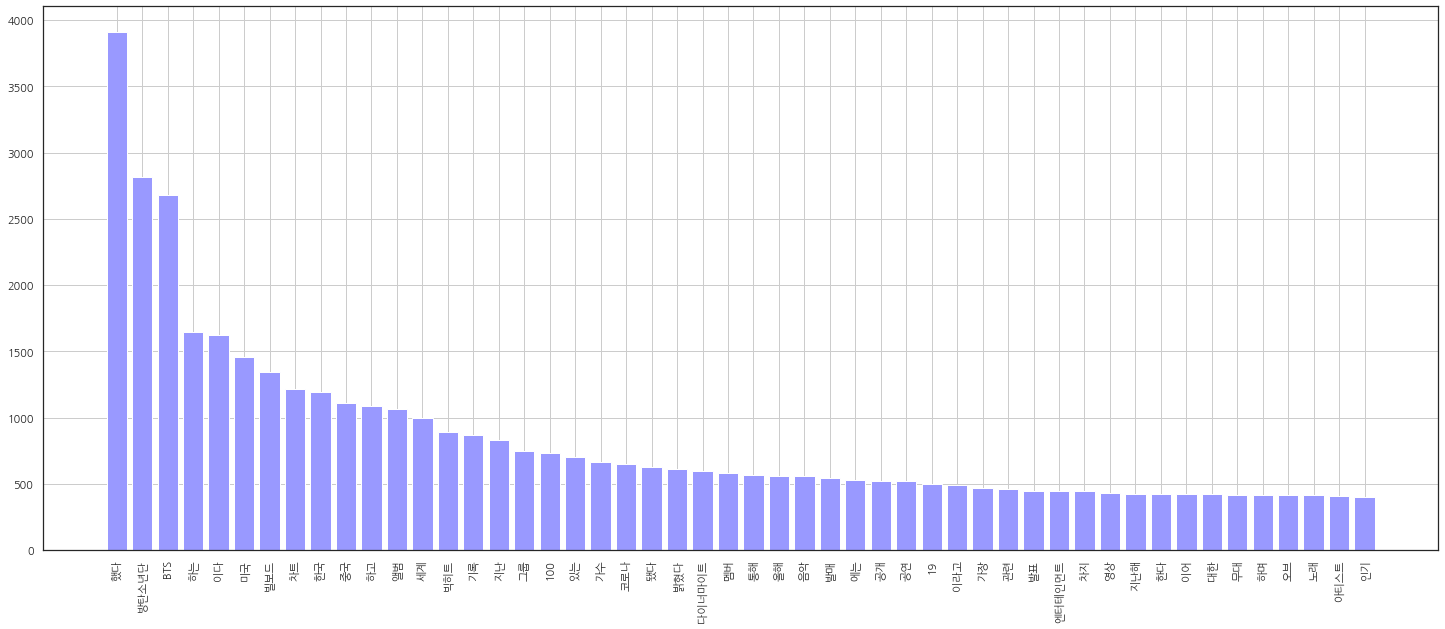


===  okt.morphs_stem  ===


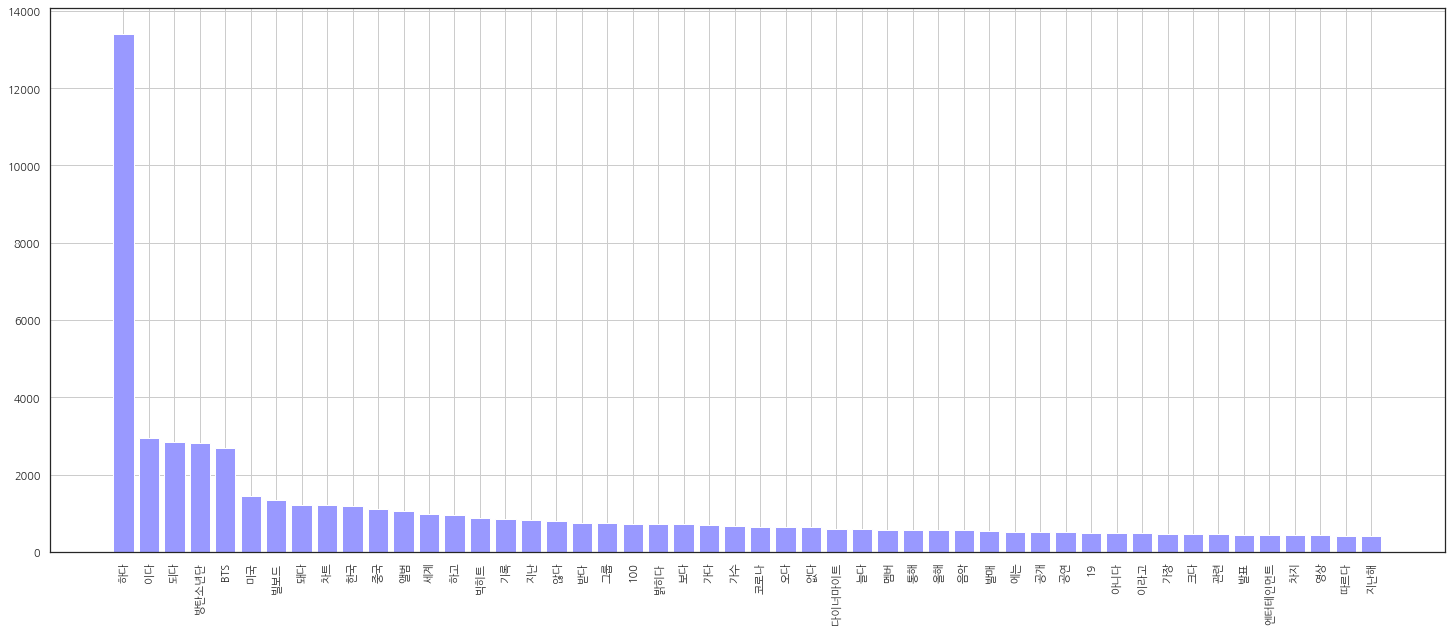


===  okt.morphs_norm  ===


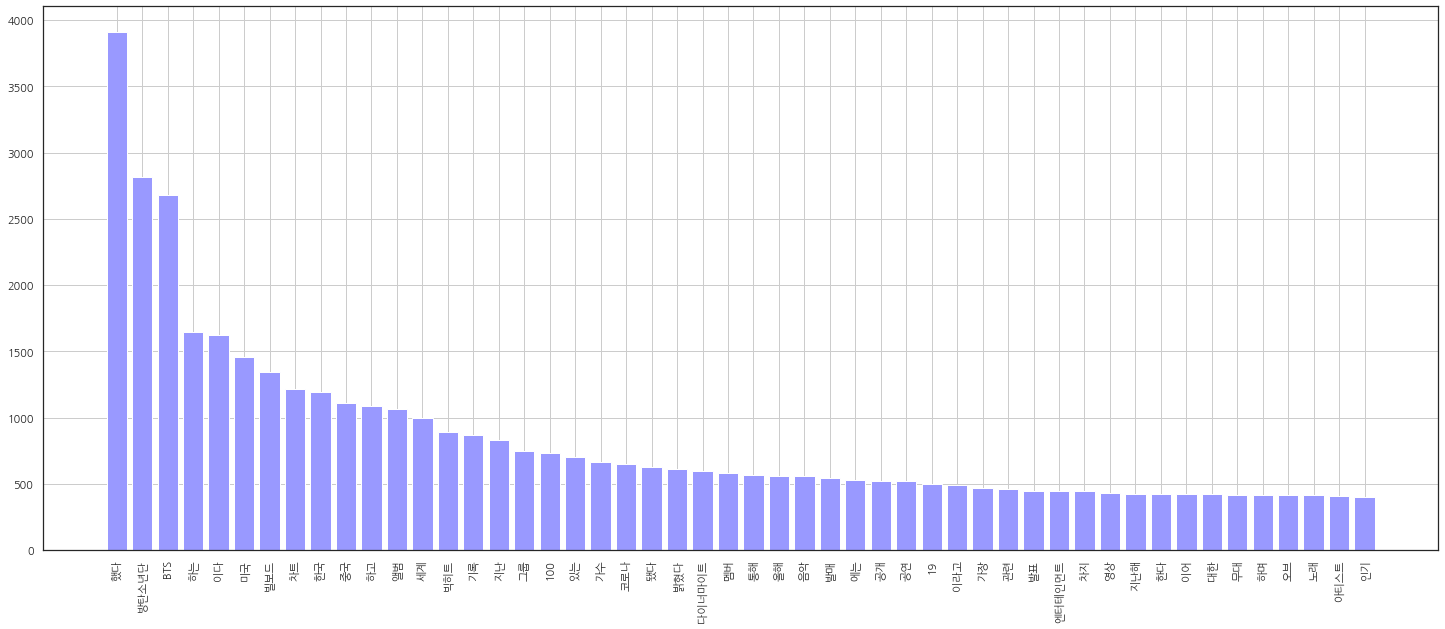


===  mecab.morphs  ===


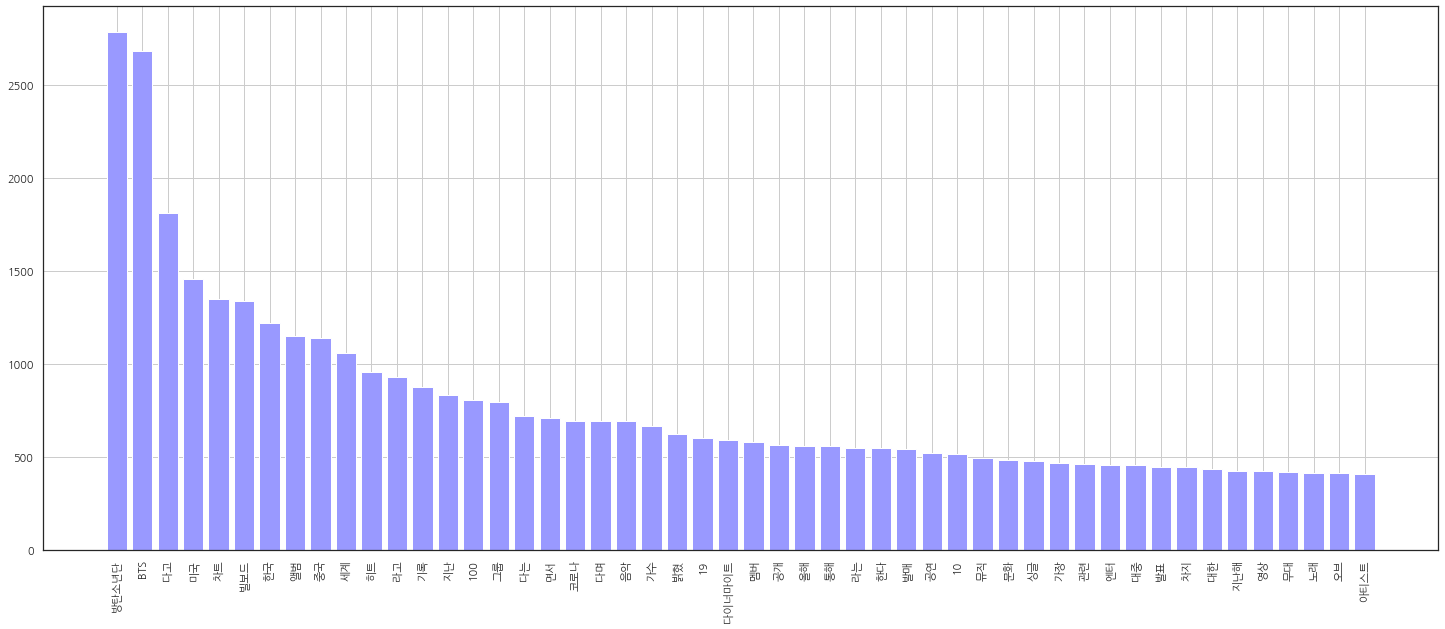


===  okt.nouns  ===


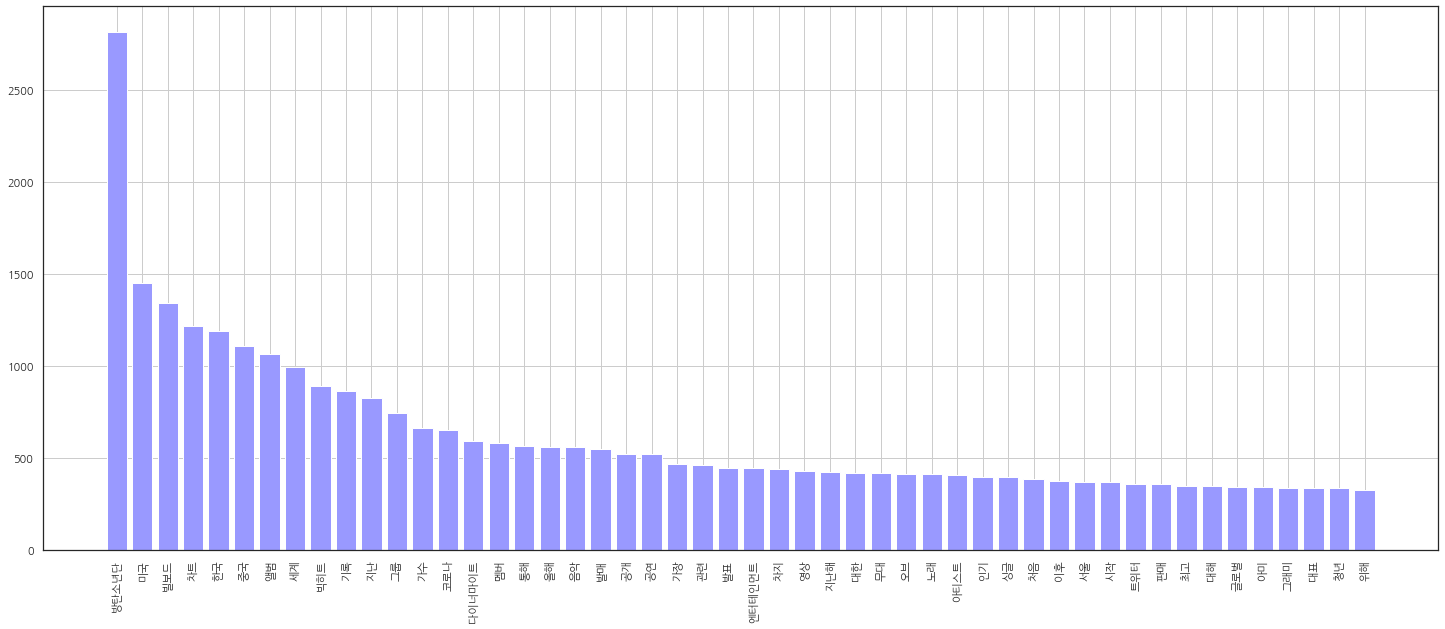


===  mecab.nouns  ===


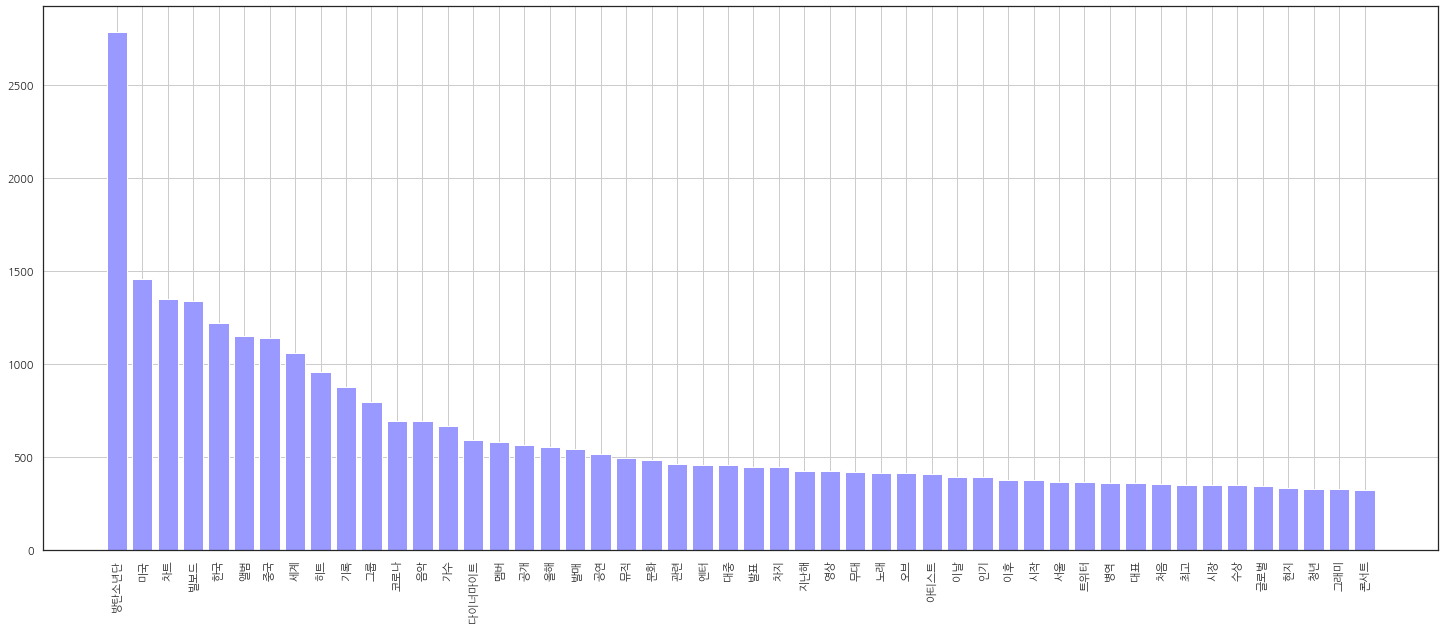


===  rhino  ===


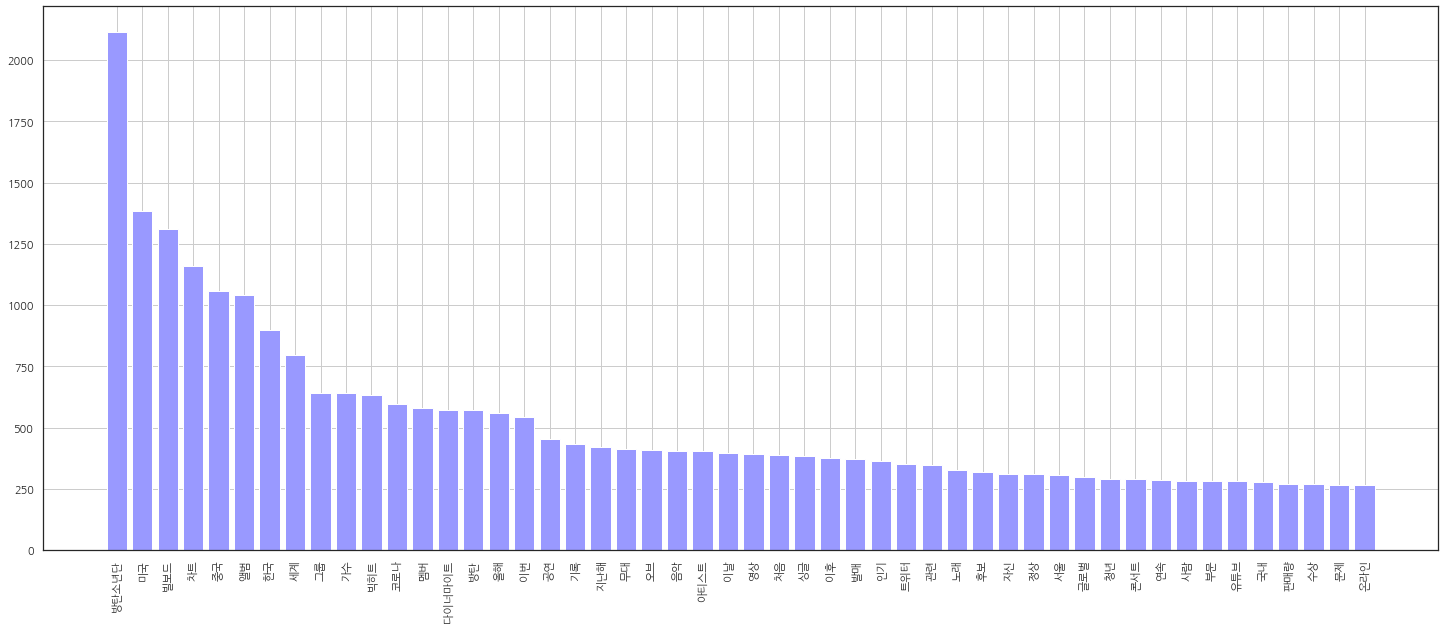

In [43]:
for col in vocab_most_df.columns.tolist():
    print('\n=== ',col,' ===')
    display_voca_count(vocab_most_df[col], voca_num=50, figsize=(25,10))

위에서 rhinoMorph와 konlpy 패키지로 7가지 경우의 대하여 토큰화 결과를 통해 문서 내 단어 개수를 확인하였습니다.  
    - 'okt.morphs'  
    - 'okt.morphs_stem'(어간추출)  
    - 'okt.morphs_norm'(정규화)  
    - 'okt.nouns'  
    - 'mecab.morphs'  
    - 'mecab.nouns'  
    - 'rhino'(NNG: 일반명사 / NNP: 고유명사 / VA: 형용사)  
    
morph 토큰화의 경우, noun 토큰화 대비 불용어가 많이 포함되어 있어 향후 분석 시 노이즈 현상이 많이 나타날 것으로 예상되었습니다.  
<br></br>
단어 수 50위 내 결과로 일부 단어를 확인해보면 다음과 같습니다.  
<br></br>

|         | okt | mecab | rhino |  
|:--------:|:---:|:-----:|:---:|  
|엔터테인먼트| (동일) | **엔터** | (동일) |  
|빅히트| (동일) | **히트** | (동일) |  
    
 <br></br>   
okt가 명사 토큰화이지만 '통해, 가장, 관련' 등 명사가 아닌 경우가 rhino의 명사 토큰화에 비해 다수 삽입되어 출현 빈도수가 높게 측정되기에 문서 토픽의 명확한 분석을 위하여 *** rhinoMorph 패키지를 최종적으로 적용하여 사용하기로 하였습니다. ***  